# Preprocessing for clinical data
Largely adapted from the [Multisurv model clinical preprocessing](https://github.com/luisvalesilva/multisurv/blob/master/data/preprocess_clinical.ipynb)

In [126]:
import pandas as pd 
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from lifelines import KaplanMeierFitter

In [127]:
gene_expression_data = 'data/data_mrna_illumina_microarray.txt'
cna_data = 'data/data_cna.txt'
clinical_data = 'data/data_clinical_patient.txt'

In [128]:
results_dir = Path('./results')
results_dir.mkdir(parents=True, exist_ok=True)

### 1.1. Exploring data

In [129]:
gene_exp_df = pd.read_table(gene_expression_data, sep='\t')
gene_exp_df.shape

(20603, 1982)

In [130]:
gene_exp_df.head()

,Hugo_Symbol,Entrez_Gene_Id,MB-0362,MB-0346,MB-0386,MB-0574,MB-0185,MB-0503,MB-0641,MB-0201,...,MB-6192,MB-4820,MB-5527,MB-5167,MB-5465,MB-5453,MB-5471,MB-5127,MB-4313,MB-4823
0,RERE,473,8.676978,9.653589,9.033589,8.814855,8.736406,9.274265,9.286585,8.437347,...,8.804947,9.991215,9.595923,9.637249,8.131637,9.606915,9.049296,8.858622,8.415867,9.902776
1,RNF165,494470,6.075331,6.687887,5.910885,5.628740,6.392422,5.908698,6.206729,6.095592,...,5.601472,7.103160,6.418987,6.203370,9.101942,7.427494,6.850000,6.550450,6.831722,7.338318
2,PHF7,51533,5.838270,5.600876,6.030718,5.849428,5.542133,5.964661,5.783374,5.737572,...,5.922894,6.181493,5.992153,6.230316,5.644587,5.927409,6.117095,5.936371,7.408960,5.875759
3,CIDEA,1149,6.397503,5.246319,10.111816,6.116868,5.184098,7.828171,8.744149,5.480091,...,6.488136,5.612846,6.241160,5.560488,5.611189,5.927031,6.374305,5.963092,9.181768,5.596873
4,TENT2,167153,7.906217,8.267256,7.959291,9.206376,8.162845,8.706646,8.518929,7.478413,...,8.534527,8.203819,8.813103,8.612911,7.798269,8.520545,8.499637,9.320207,6.804085,8.436732


In [131]:
cna_df = pd.read_table(cna_data, sep='\t')
cna_df.shape

(22544, 2175)

In [132]:
clinical_df = pd.read_table(clinical_data, sep='\t')
clinical_df.shape

(2513, 24)

In [133]:
clinical_df.head()

,#Patient Identifier,Lymph nodes examined positive,Nottingham prognostic index,Cellularity,Chemotherapy,Cohort,ER status measured by IHC,HER2 status measured by SNP6,Hormone Therapy,Inferred Menopausal State,...,Overall Survival Status,Pam50 + Claudin-low subtype,3-Gene classifier subtype,Patient's Vital Status,Primary Tumor Laterality,Radio Therapy,Tumor Other Histologic Subtype,Type of Breast Surgery,Relapse Free Status,Relapse Free Status (Months)
0,#Identifier to uniquely specify a patient.,Number of lymphnodes positive,Nottingham prognostic index,Tumor Content,Chemotherapy.,Cohort.,ER status measured by IHC,HER2 status measured by SNP6,Hormone Therapy,Inferred Menopausal State,...,Overall patient survival status.,Pam50 + Claudin-low subtype,3-Gene classifier subtype,The survival state of the person.,"For tumors in paired organs, designates the si...",Radio Therapy,Text to describe a tumor's histologic subtype ...,Type of Breast Surgery,Relapse Free Status (Recurred = cases where th...,Time until last follow-up or relapse (in months)
1,#STRING,STRING,NUMBER,STRING,STRING,STRING,STRING,STRING,STRING,STRING,...,STRING,STRING,STRING,STRING,STRING,STRING,STRING,STRING,STRING,NUMBER
2,#1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
3,PATIENT_ID,LYMPH_NODES_EXAMINED_POSITIVE,NPI,CELLULARITY,CHEMOTHERAPY,COHORT,ER_IHC,HER2_SNP6,HORMONE_THERAPY,INFERRED_MENOPAUSAL_STATE,...,OS_STATUS,CLAUDIN_SUBTYPE,THREEGENE,VITAL_STATUS,LATERALITY,RADIO_THERAPY,HISTOLOGICAL_SUBTYPE,BREAST_SURGERY,RFS_STATUS,RFS_MONTHS
4,MB-0000,10,6.044,NaN,NO,1,Positve,NEUTRAL,YES,Post,...,0:LIVING,claudin-low,ER-/HER2-,Living,Right,YES,Ductal/NST,MASTECTOMY,0:Not Recurred,138.65


### 1.1. Dropping unnecessary rows and columns from clinical data

In [134]:
# Dropping unnecessary rows and columns
clinical_df = clinical_df.drop(clinical_df.index[:4]).reset_index() #headers
clinical_df = clinical_df.drop(clinical_df.columns[0],axis=1) #index column
clinical_df.head()

,#Patient Identifier,Lymph nodes examined positive,Nottingham prognostic index,Cellularity,Chemotherapy,Cohort,ER status measured by IHC,HER2 status measured by SNP6,Hormone Therapy,Inferred Menopausal State,...,Overall Survival Status,Pam50 + Claudin-low subtype,3-Gene classifier subtype,Patient's Vital Status,Primary Tumor Laterality,Radio Therapy,Tumor Other Histologic Subtype,Type of Breast Surgery,Relapse Free Status,Relapse Free Status (Months)
0,MB-0000,10,6.044,NaN,NO,1,Positve,NEUTRAL,YES,Post,...,0:LIVING,claudin-low,ER-/HER2-,Living,Right,YES,Ductal/NST,MASTECTOMY,0:Not Recurred,138.65
1,MB-0002,0,4.02,High,NO,1,Positve,NEUTRAL,YES,Pre,...,0:LIVING,LumA,ER+/HER2- High Prolif,Living,Right,YES,Ductal/NST,BREAST CONSERVING,0:Not Recurred,83.52
2,MB-0005,1,4.03,High,YES,1,Positve,NEUTRAL,YES,Pre,...,1:DECEASED,LumB,NaN,Died of Disease,Right,NO,Ductal/NST,MASTECTOMY,1:Recurred,151.28
3,MB-0006,3,4.05,Moderate,YES,1,Positve,NEUTRAL,YES,Pre,...,0:LIVING,LumB,NaN,Living,Right,YES,Mixed,MASTECTOMY,0:Not Recurred,162.76
4,MB-0008,8,6.08,High,YES,1,Positve,NEUTRAL,YES,Post,...,1:DECEASED,LumB,ER+/HER2- High Prolif,Died of Disease,Right,YES,Mixed,MASTECTOMY,1:Recurred,18.55


### 1.2 Selecting patients that have all 3 data types: gene expression, CNA, clinical

In [135]:
gene_exp_patients = set(gene_exp_df.columns[2:])
cna_patients = set(cna_df.columns[2:])
clinical_patients = set(clinical_df['#Patient Identifier'])

common_patients = gene_exp_patients.intersection(cna_patients, clinical_patients)

gene_exp_columns_to_drop = [col for col in gene_exp_df.columns[2:] if col not in common_patients]
gene_exp_df = gene_exp_df.drop(columns=gene_exp_columns_to_drop)

cna_columns_to_drop = [col for col in cna_df.columns[2:] if col not in common_patients]
cna_df = cna_df.drop(columns=cna_columns_to_drop)

clinical_df = clinical_df[clinical_df['#Patient Identifier'].isin(common_patients)]

In [136]:
gene_exp_df.shape

(20603, 1982)

In [137]:
cna_df.shape

(22544, 1982)

In [138]:
clinical_df.shape

(1980, 24)

### 1.3 Checking for missing clinical data

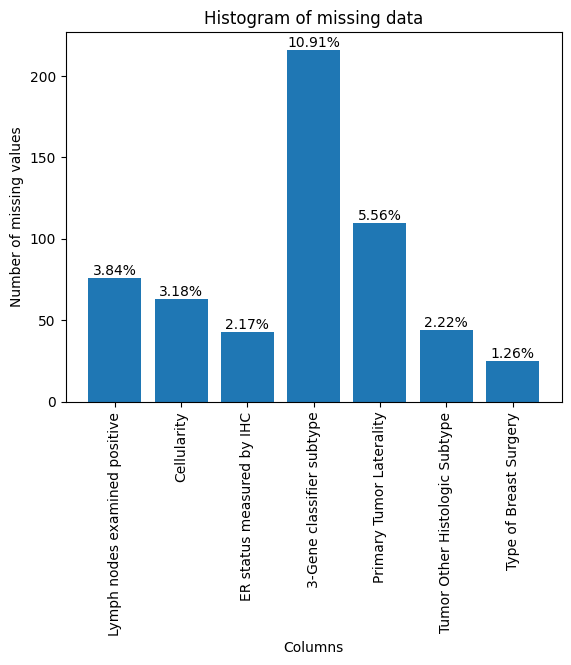

In [139]:
n = clinical_df.shape[0]

missing_counts = {}  # Dictionary to store missing value counts for each column

for col in clinical_df.columns:
    if col == '#Patient Identifier':
        continue

    n_missing = clinical_df[col].isnull().sum()
    if n_missing>1:  
        missing_counts[col] = n_missing

plt.bar(missing_counts.keys(), missing_counts.values())
plt.xlabel('Columns')
plt.ylabel('Number of missing values')
plt.title('Histogram of missing data')
for i, (col, count) in enumerate(missing_counts.items()):
    percentage = count / n * 100
    plt.text(i, count, f'{percentage:.2f}%', ha='center', va='bottom')
plt.xticks(rotation=90)  
plt.savefig(results_dir/'missing_data_hist.png',dpi=300)
plt.show()

In [140]:
# Making sure all patients are female
clinical_df['Sex'].value_counts()

Sex
Female    1980
Name: count, dtype: int64

### 1.4. Selecting clinical features
For now selecting most of the features, but can fine tune later based on cancer subtypes

In [141]:
clinical_df.columns

Index(['#Patient Identifier', 'Lymph nodes examined positive',
       'Nottingham prognostic index', 'Cellularity', 'Chemotherapy', 'Cohort',
       'ER status measured by IHC', 'HER2 status measured by SNP6',
       'Hormone Therapy', 'Inferred Menopausal State', 'Sex',
       'Integrative Cluster', 'Age at Diagnosis', 'Overall Survival (Months)',
       'Overall Survival Status', 'Pam50 + Claudin-low subtype',
       '3-Gene classifier subtype', 'Patient's Vital Status',
       'Primary Tumor Laterality', 'Radio Therapy',
       'Tumor Other Histologic Subtype', 'Type of Breast Surgery',
       'Relapse Free Status', 'Relapse Free Status (Months)'],
      dtype='object')

In [142]:
# Selecting variables
label_cols = ['#Patient Identifier', "Patient's Vital Status", 'Overall Survival (Months)']
keep_cols = ['Lymph nodes examined positive', 'Nottingham prognostic index', 'Cellularity', 'Chemotherapy','ER status measured by IHC',
            'HER2 status measured by SNP6', 'Hormone Therapy', 'Inferred Menopausal State', 'Integrative Cluster', 'Age at Diagnosis', 
             'Pam50 + Claudin-low subtype', '3-Gene classifier subtype', 'Primary Tumor Laterality', 'Tumor Other Histologic Subtype',  
             'Radio Therapy','Type of Breast Surgery', 'Relapse Free Status', 'Relapse Free Status (Months)']
columns_to_drop = [col for col in clinical_df.columns if col not in label_cols + keep_cols]
clinical_df = clinical_df.drop(columns=columns_to_drop)
clinical_df.shape

(1980, 21)

In [143]:
clinical_df.head()

,#Patient Identifier,Lymph nodes examined positive,Nottingham prognostic index,Cellularity,Chemotherapy,ER status measured by IHC,HER2 status measured by SNP6,Hormone Therapy,Inferred Menopausal State,Integrative Cluster,...,Overall Survival (Months),Pam50 + Claudin-low subtype,3-Gene classifier subtype,Patient's Vital Status,Primary Tumor Laterality,Radio Therapy,Tumor Other Histologic Subtype,Type of Breast Surgery,Relapse Free Status,Relapse Free Status (Months)
0,MB-0000,10,6.044,NaN,NO,Positve,NEUTRAL,YES,Post,4ER+,...,140.5,claudin-low,ER-/HER2-,Living,Right,YES,Ductal/NST,MASTECTOMY,0:Not Recurred,138.65
1,MB-0002,0,4.02,High,NO,Positve,NEUTRAL,YES,Pre,4ER+,...,84.63333333,LumA,ER+/HER2- High Prolif,Living,Right,YES,Ductal/NST,BREAST CONSERVING,0:Not Recurred,83.52
2,MB-0005,1,4.03,High,YES,Positve,NEUTRAL,YES,Pre,3,...,163.7,LumB,NaN,Died of Disease,Right,NO,Ductal/NST,MASTECTOMY,1:Recurred,151.28
3,MB-0006,3,4.05,Moderate,YES,Positve,NEUTRAL,YES,Pre,9,...,164.9333333,LumB,NaN,Living,Right,YES,Mixed,MASTECTOMY,0:Not Recurred,162.76
4,MB-0008,8,6.08,High,YES,Positve,NEUTRAL,YES,Post,9,...,41.36666667,LumB,ER+/HER2- High Prolif,Died of Disease,Right,YES,Mixed,MASTECTOMY,1:Recurred,18.55


In [144]:
clinical_df["Patient's Vital Status"].value_counts()

Patient's Vital Status
Living                  837
Died of Disease         646
Died of Other Causes    496
Name: count, dtype: int64

### 1.6. Labeling data
L - 0, D - 1

In [145]:
clinical_df["Patient's Vital Status"] = clinical_df["Patient's Vital Status"].replace('Died of Other Causes', pd.NA)
clinical_df = clinical_df.dropna(subset=["Patient's Vital Status"])
clinical_df['event'] = clinical_df["Patient's Vital Status"].apply(lambda x: 0 if x == 'Living' else 1)
clinical_df['event'].value_counts()
#Get overall survival in years
clinical_df['time'] = clinical_df["Overall Survival (Months)"].astype(float)/12
clinical_df.head()

,#Patient Identifier,Lymph nodes examined positive,Nottingham prognostic index,Cellularity,Chemotherapy,ER status measured by IHC,HER2 status measured by SNP6,Hormone Therapy,Inferred Menopausal State,Integrative Cluster,...,3-Gene classifier subtype,Patient's Vital Status,Primary Tumor Laterality,Radio Therapy,Tumor Other Histologic Subtype,Type of Breast Surgery,Relapse Free Status,Relapse Free Status (Months),event,time
0,MB-0000,10,6.044,NaN,NO,Positve,NEUTRAL,YES,Post,4ER+,...,ER-/HER2-,Living,Right,YES,Ductal/NST,MASTECTOMY,0:Not Recurred,138.65,0,11.708333
1,MB-0002,0,4.02,High,NO,Positve,NEUTRAL,YES,Pre,4ER+,...,ER+/HER2- High Prolif,Living,Right,YES,Ductal/NST,BREAST CONSERVING,0:Not Recurred,83.52,0,7.052778
2,MB-0005,1,4.03,High,YES,Positve,NEUTRAL,YES,Pre,3,...,NaN,Died of Disease,Right,NO,Ductal/NST,MASTECTOMY,1:Recurred,151.28,1,13.641667
3,MB-0006,3,4.05,Moderate,YES,Positve,NEUTRAL,YES,Pre,9,...,NaN,Living,Right,YES,Mixed,MASTECTOMY,0:Not Recurred,162.76,0,13.744444
4,MB-0008,8,6.08,High,YES,Positve,NEUTRAL,YES,Post,9,...,ER+/HER2- High Prolif,Died of Disease,Right,YES,Mixed,MASTECTOMY,1:Recurred,18.55,1,3.447222


In [146]:
clinical_df.set_index('#Patient Identifier', inplace=True)
clinical_df.head()

,Lymph nodes examined positive,Nottingham prognostic index,Cellularity,Chemotherapy,ER status measured by IHC,HER2 status measured by SNP6,Hormone Therapy,Inferred Menopausal State,Integrative Cluster,Age at Diagnosis,...,3-Gene classifier subtype,Patient's Vital Status,Primary Tumor Laterality,Radio Therapy,Tumor Other Histologic Subtype,Type of Breast Surgery,Relapse Free Status,Relapse Free Status (Months),event,time
#Patient Identifier,,,,,,,,,,,,,,,,,,,,,
MB-0000,10,6.044,NaN,NO,Positve,NEUTRAL,YES,Post,4ER+,75.65,...,ER-/HER2-,Living,Right,YES,Ductal/NST,MASTECTOMY,0:Not Recurred,138.65,0,11.708333
MB-0002,0,4.02,High,NO,Positve,NEUTRAL,YES,Pre,4ER+,43.19,...,ER+/HER2- High Prolif,Living,Right,YES,Ductal/NST,BREAST CONSERVING,0:Not Recurred,83.52,0,7.052778
MB-0005,1,4.03,High,YES,Positve,NEUTRAL,YES,Pre,3,48.87,...,NaN,Died of Disease,Right,NO,Ductal/NST,MASTECTOMY,1:Recurred,151.28,1,13.641667
MB-0006,3,4.05,Moderate,YES,Positve,NEUTRAL,YES,Pre,9,47.68,...,NaN,Living,Right,YES,Mixed,MASTECTOMY,0:Not Recurred,162.76,0,13.744444
MB-0008,8,6.08,High,YES,Positve,NEUTRAL,YES,Post,9,76.97,...,ER+/HER2- High Prolif,Died of Disease,Right,YES,Mixed,MASTECTOMY,1:Recurred,18.55,1,3.447222


## 1.6. Train-val-test splits

In [151]:
X = clinical_df
y = clinical_df[['time']]
X_train, X_val, _, _ = train_test_split(X, y, test_size=0.1, stratify=clinical_df[['event']], random_state=42)

X = X_train
y = X_train[['time']]
X_train, X_test, _, _ = train_test_split(
    X, y, test_size=0.15, random_state=42, stratify=X_train[['event']])

In [156]:
def get_split_group(id_code):
    if id_code in list(X_train.index):
        return 'train'
    elif id_code in X_val.index:
        return 'val'
    elif id_code in X_test.index:
        return 'test'
    else:
        print('Found NaN!')

In [157]:
clinical_df['group'] = 'Missing'
clinical_df['group'] = [get_split_group(x) for x in list(clinical_df.index)]

In [159]:
clinical_df['group'].value_counts()

group
train    1133
test      201
val       149
Name: count, dtype: int64

In [160]:
clinical_df.head()

,Lymph nodes examined positive,Nottingham prognostic index,Cellularity,Chemotherapy,ER status measured by IHC,HER2 status measured by SNP6,Hormone Therapy,Inferred Menopausal State,Integrative Cluster,Age at Diagnosis,...,Patient's Vital Status,Primary Tumor Laterality,Radio Therapy,Tumor Other Histologic Subtype,Type of Breast Surgery,Relapse Free Status,Relapse Free Status (Months),event,time,group
#Patient Identifier,,,,,,,,,,,,,,,,,,,,,
MB-0000,10,6.044,NaN,NO,Positve,NEUTRAL,YES,Post,4ER+,75.65,...,Living,Right,YES,Ductal/NST,MASTECTOMY,0:Not Recurred,138.65,0,11.708333,train
MB-0002,0,4.02,High,NO,Positve,NEUTRAL,YES,Pre,4ER+,43.19,...,Living,Right,YES,Ductal/NST,BREAST CONSERVING,0:Not Recurred,83.52,0,7.052778,val
MB-0005,1,4.03,High,YES,Positve,NEUTRAL,YES,Pre,3,48.87,...,Died of Disease,Right,NO,Ductal/NST,MASTECTOMY,1:Recurred,151.28,1,13.641667,train
MB-0006,3,4.05,Moderate,YES,Positve,NEUTRAL,YES,Pre,9,47.68,...,Living,Right,YES,Mixed,MASTECTOMY,0:Not Recurred,162.76,0,13.744444,train
MB-0008,8,6.08,High,YES,Positve,NEUTRAL,YES,Post,9,76.97,...,Died of Disease,Right,YES,Mixed,MASTECTOMY,1:Recurred,18.55,1,3.447222,test


In [161]:
train = clinical_df.loc[clinical_df['group']=='train']
val = clinical_df.loc[clinical_df['group']=='val']
test = clinical_df.loc[clinical_df['group']=='test']

<Axes: title={'center': 'Training data'}, xlabel='Time (years)'>

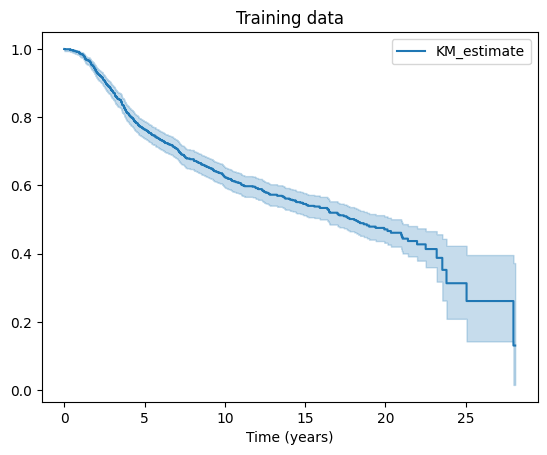

In [162]:
kmf = KaplanMeierFitter()
kmf.fit(train['time'], event_observed=train['event'])
ax = kmf.plot(title='Training data')
ax.set_xlabel('Time (years)')
ax

<Axes: title={'center': 'Test data'}, xlabel='Time (years)'>

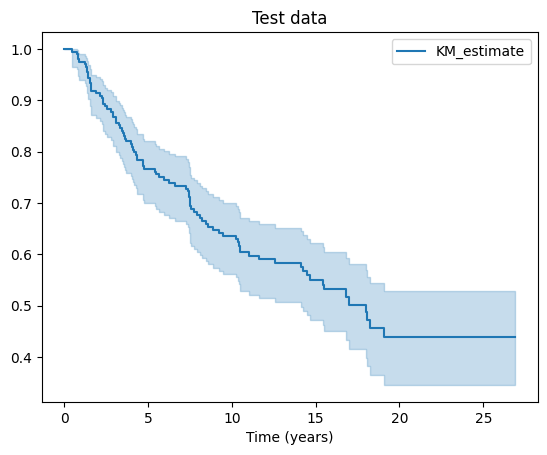

In [163]:
kmf = KaplanMeierFitter()
kmf.fit(test['time'], event_observed=test['event'])
ax = kmf.plot(title='Test data')
ax.set_xlabel('Time (years)')
ax

## Input missing numeric data with median value and encode categorical variables

In [168]:
print('~~ MISSING DATA ~~')
print()
skip = ['project_id', 'days_to_death', 'days_to_last_follow_up']

n = clinical_df.shape[0]

for v in clinical_df.columns:
    if v not in skip:
        n_missing = sum(clinical_df[v].isnull())
        if n_missing > 0:
            print(f'{v}: {n_missing} ({round(n_missing / n * 100, 2)}%)')

~~ MISSING DATA ~~

Lymph nodes examined positive: 60 (4.05%)
Cellularity: 49 (3.3%)
ER status measured by IHC: 31 (2.09%)
3-Gene classifier subtype: 158 (10.65%)
Primary Tumor Laterality: 82 (5.53%)
Tumor Other Histologic Subtype: 33 (2.23%)
Type of Breast Surgery: 18 (1.21%)


In [170]:
def input_missing_values(feature, df):
    train_subset = df.loc[df['group'] == 'train', feature]
    try:
        input_value = train_subset.median()
        print(f'Median "{feature}": {input_value}')
    except TypeError:
        input_value = train_subset.mode().iloc[0]
        print(f'Mode "{feature}": {input_value}')

    df[feature].fillna(input_value, inplace=True)
    
    return df

In [172]:
clinical_df = input_missing_values(feature='Lymph nodes examined positive', df=clinical_df)

Median "Lymph nodes examined positive": 1.0


In [173]:
print('~~ MISSING DATA ~~')
print()
skip = ['project_id', 'days_to_death', 'days_to_last_follow_up']

n = clinical_df.shape[0]

for v in clinical_df.columns:
    if v not in skip:
        n_missing = sum(clinical_df[v].isnull())
        if n_missing > 0:
            print(f'{v}: {n_missing} ({round(n_missing / n * 100, 2)}%)')

~~ MISSING DATA ~~

Cellularity: 49 (3.3%)
ER status measured by IHC: 31 (2.09%)
3-Gene classifier subtype: 158 (10.65%)
Primary Tumor Laterality: 82 (5.53%)
Tumor Other Histologic Subtype: 33 (2.23%)
Type of Breast Surgery: 18 (1.21%)


In [ ]:
id_groups = {
    'train': list(clinical.loc[clinical['group'] == 'train', ].index),
    'val': list(clinical.loc[clinical['group'] == 'val', ].index),
    'test': list(clinical.loc[clinical['group'] == 'test', ].index)}

In [ ]:
skip = ['']

In [ ]:
def min_max_scale(data, features, groups):
    train = data.loc[data.index.isin(groups['train']), features]

    scaler = MinMaxScaler()
    columns = train.columns
    scaler = scaler.fit(train[columns])
    
    data.loc[data.index.isin(groups['train']), features] = scaler.transform(
        train)
    data.loc[data.index.isin(groups['val']), features] = scaler.transform(
        data.loc[data.index.isin(groups['val']), features])
    data.loc[data.index.isin(groups['test']), features] = scaler.transform(
        data.loc[data.index.isin(groups['test']), features])
    
    return data

In [ ]:
clinical = min_max_scale(data=clinical, features=continuous, groups=id_groups)

### 1.7. Exploring feature distributions

In [21]:
def plot_histogram(dfs, column_name, file_path, dpi=300, fontsize=8):
    fig, ax = plt.subplots()
    
    for df, label in dfs:
        value_counts = df[column_name].value_counts()
        ax.bar(value_counts.index, value_counts.values, label=label, alpha=0.5)
        
    ax.set_xlabel(column_name)
    ax.set_ylabel('Number of Patients')
    ax.set_title(f'Histogram of {column_name}')
    ax.legend()  
    
    ax.tick_params(axis='x', labelsize=fontsize)  
    
    plt.savefig(file_path, dpi=dpi) 
    plt.show()

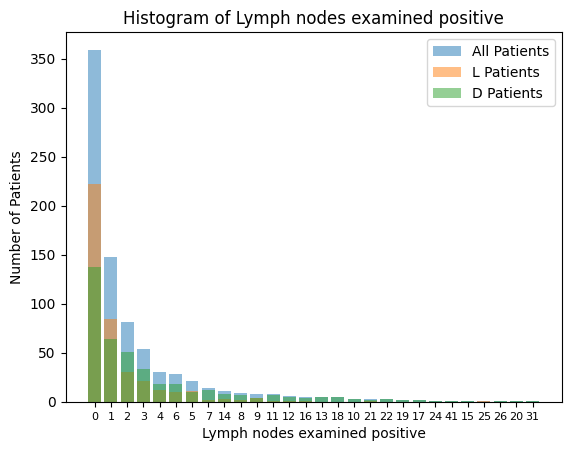

In [22]:
plot_histogram([(clinical_df, 'All Patients'), (clinical_L_df, 'L Patients'), (clinical_D_df, 'D Patients')],
               'Lymph nodes examined positive', 
               results_dir / 'lymph_nodes_hist_combined.png')

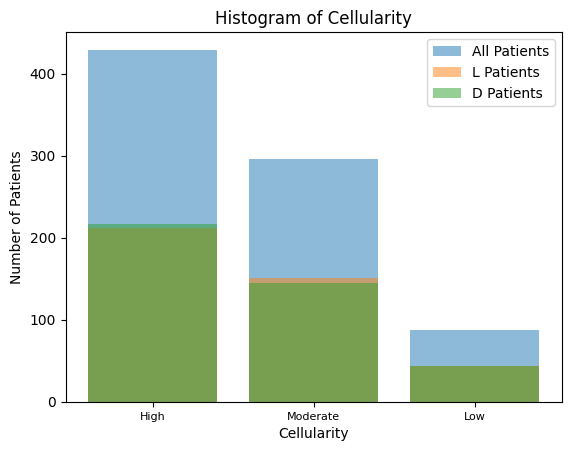

In [390]:
plot_histogram([(clinical_df, 'All Patients'), (clinical_L_df, 'L Patients'), (clinical_D_df, 'D Patients')],
               'Cellularity', 
               results_dir / 'cellularity_hist_combined.png')

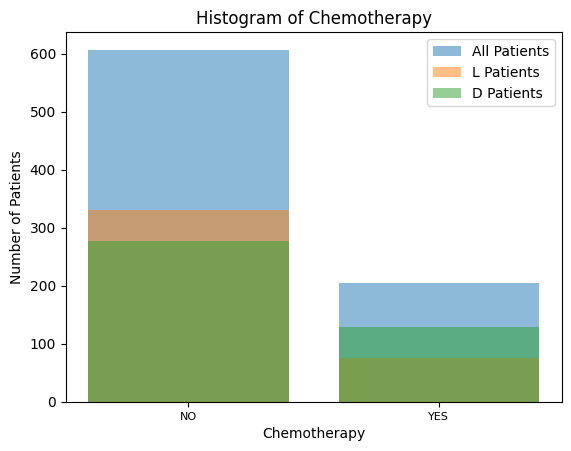

In [391]:
plot_histogram([(clinical_df, 'All Patients'), (clinical_L_df, 'L Patients'), (clinical_D_df, 'D Patients')],
               'Chemotherapy', 
               results_dir / 'chemotherapy_hist_combined.png')

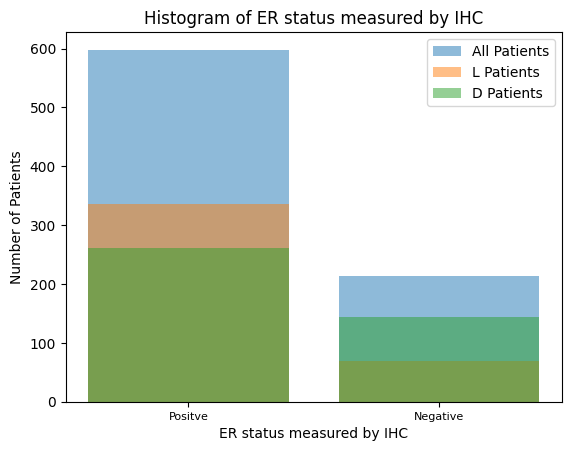

In [392]:
plot_histogram([(clinical_df, 'All Patients'), (clinical_L_df, 'L Patients'), (clinical_D_df, 'D Patients')],
               'ER status measured by IHC', 
               results_dir / 'ER_IHC_status_hist_combined.png')

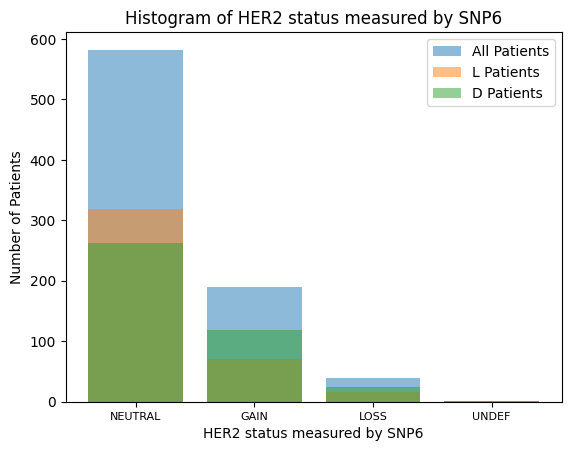

In [394]:
plot_histogram([(clinical_df, 'All Patients'), (clinical_L_df, 'L Patients'), (clinical_D_df, 'D Patients')],
               'HER2 status measured by SNP6', 
               results_dir / 'HER2_status_hist_combined.png')

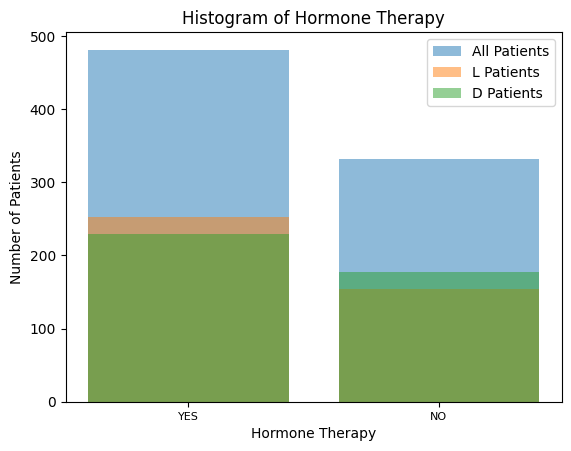

In [395]:
plot_histogram([(clinical_df, 'All Patients'), (clinical_L_df, 'L Patients'), (clinical_D_df, 'D Patients')],
               'Hormone Therapy', 
               results_dir / 'hormone_therapy_hist_combined.png')

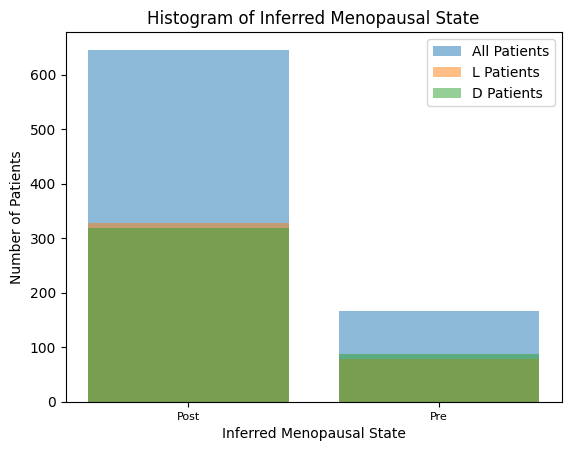

In [396]:
plot_histogram([(clinical_df, 'All Patients'), (clinical_L_df, 'L Patients'), (clinical_D_df, 'D Patients')],
               'Inferred Menopausal State', 
               results_dir / 'inferred_menopausal_state_hist_combined.png')

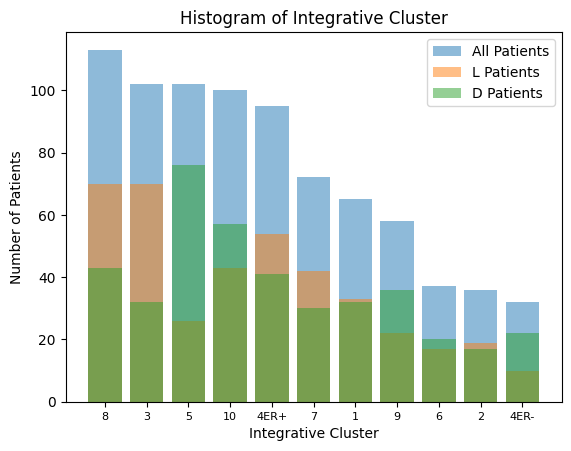

In [397]:
plot_histogram([(clinical_df, 'All Patients'), (clinical_L_df, 'L Patients'), (clinical_D_df, 'D Patients')],
               'Integrative Cluster', 
               results_dir / 'integrative_cluster_hist_combined.png')

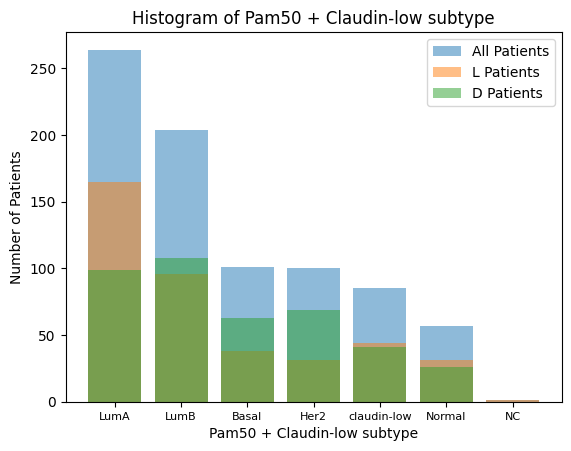

In [398]:
plot_histogram([(clinical_df, 'All Patients'), (clinical_L_df, 'L Patients'), (clinical_D_df, 'D Patients')],
               'Pam50 + Claudin-low subtype', 
               results_dir / 'Pam50_sybtype_hist_combined.png')

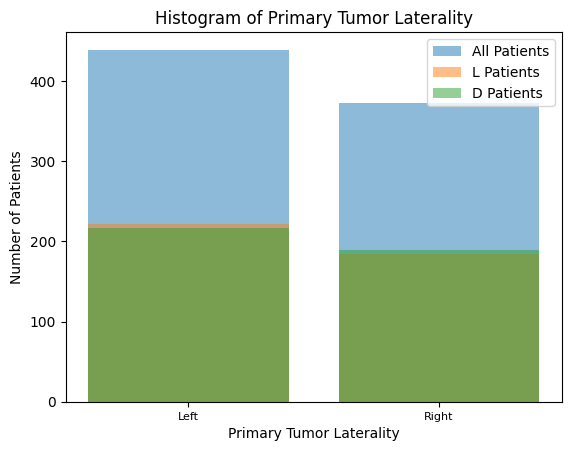

In [399]:
plot_histogram([(clinical_df, 'All Patients'), (clinical_L_df, 'L Patients'), (clinical_D_df, 'D Patients')],
               'Primary Tumor Laterality', 
               results_dir / 'laterality_hist_combined.png')

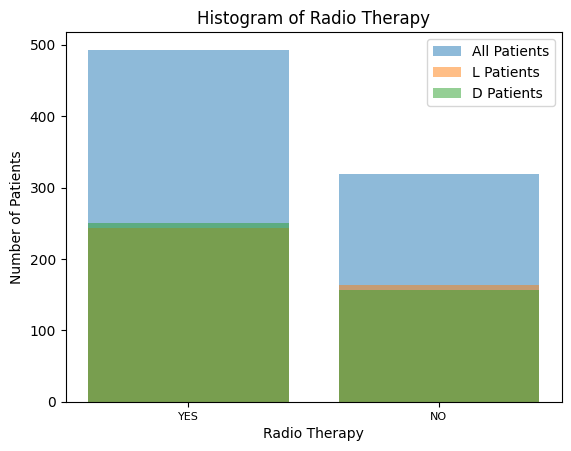

In [400]:
plot_histogram([(clinical_df, 'All Patients'), (clinical_L_df, 'L Patients'), (clinical_D_df, 'D Patients')],
               'Radio Therapy', 
               results_dir / 'radio_therapy_hist_combined.png')

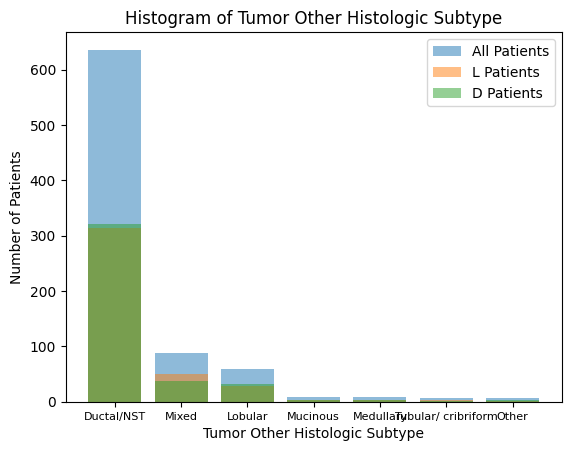

In [401]:
plot_histogram([(clinical_df, 'All Patients'), (clinical_L_df, 'L Patients'), (clinical_D_df, 'D Patients')],
               'Tumor Other Histologic Subtype', 
               results_dir / 'tumor_other_subtype_hist_combined.png')

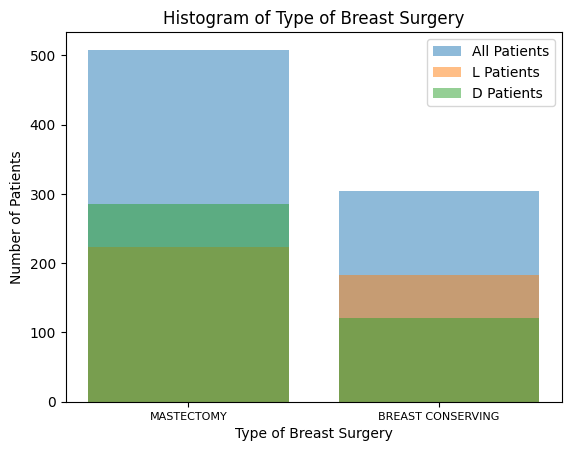

In [402]:
plot_histogram([(clinical_df, 'All Patients'), (clinical_L_df, 'L Patients'), (clinical_D_df, 'D Patients')],
               'Type of Breast Surgery', 
               results_dir / 'type_breast_surgery_hist_combined.png')

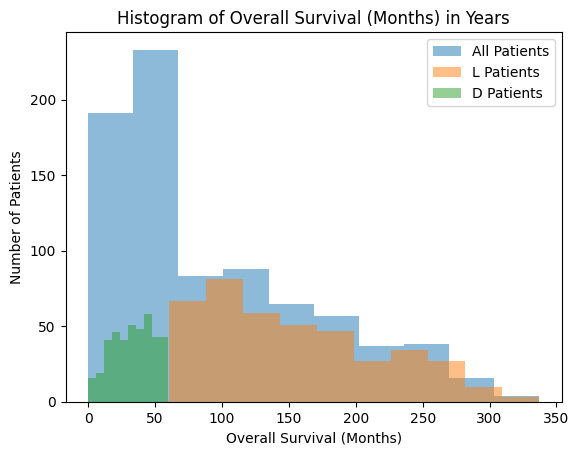

In [404]:
fig, ax = plt.subplots()
column = 'Overall Survival (Months)'

clinical_df[column].astype(float).plot(kind='hist', ax=ax, alpha=0.5, label='All Patients')
clinical_L_df[column].astype(float).plot(kind='hist', ax=ax, alpha=0.5, label='L Patients')
clinical_D_df[column].astype(float).plot(kind='hist', ax=ax, alpha=0.5, label='D Patients')

ax.set_title(f'Histogram of {column} in Years')
ax.set_xlabel(column)
ax.set_ylabel('Number of Patients')
ax.legend()

plt.savefig(results_dir / 'survival_hist_combined.png', dpi=300)

plt.show()

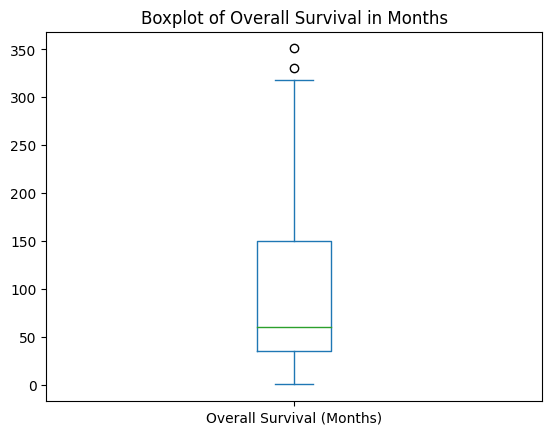

In [313]:
clinical_df['Overall Survival (Months)'].astype(float).plot(kind='box', 
                                                            title = 'Boxplot of Overall Survival in Months')
plt.savefig(results_dir/'survival_box.png',dpi=300)

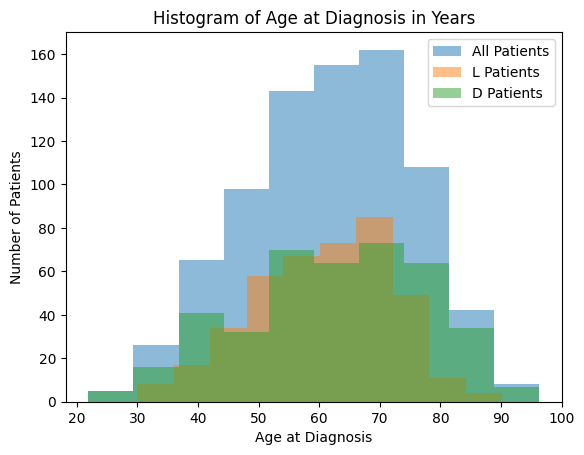

In [403]:
fig, ax = plt.subplots()
column = 'Age at Diagnosis'

clinical_df[column].astype(float).plot(kind='hist', ax=ax, alpha=0.5, label='All Patients')
clinical_L_df[column].astype(float).plot(kind='hist', ax=ax, alpha=0.5, label='L Patients')
clinical_D_df[column].astype(float).plot(kind='hist', ax=ax, alpha=0.5, label='D Patients')

ax.set_title(f'Histogram of {column} in Years')
ax.set_xlabel(column)
ax.set_ylabel('Number of Patients')
ax.legend()

plt.savefig(results_dir / 'age_hist_combined.png', dpi=300)

plt.show()

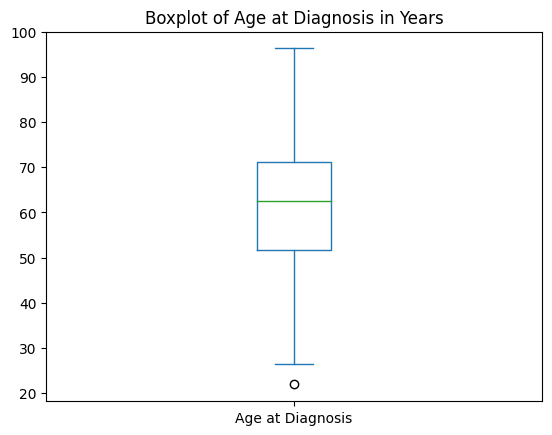

In [316]:
clinical_df['Age at Diagnosis'].astype(float).plot(kind='box', 
                                                    title = 'Boxplot of Age at Diagnosis in Years')
plt.savefig(results_dir/'age_box.png')

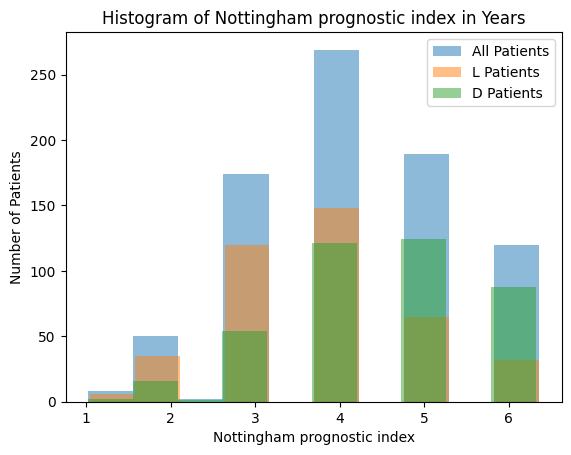

In [405]:
fig, ax = plt.subplots()
column = 'Nottingham prognostic index'

clinical_df[column].astype(float).plot(kind='hist', ax=ax, alpha=0.5, label='All Patients')
clinical_L_df[column].astype(float).plot(kind='hist', ax=ax, alpha=0.5, label='L Patients')
clinical_D_df[column].astype(float).plot(kind='hist', ax=ax, alpha=0.5, label='D Patients')

ax.set_title(f'Histogram of {column} in Years')
ax.set_xlabel(column)
ax.set_ylabel('Number of Patients')
ax.legend()

plt.savefig(results_dir / 'NPI_hist_combined.png', dpi=300)

plt.show()

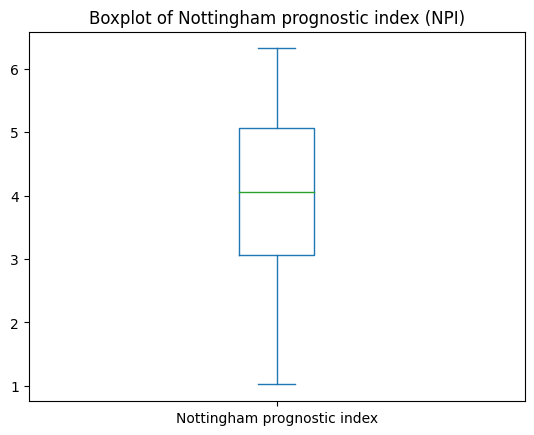

In [319]:
clinical_df['Nottingham prognostic index'].astype(float).plot(kind='box', 
                                                            title = 'Boxplot of Nottingham prognostic index (NPI)')
plt.savefig(results_dir/'NPI_box.png')

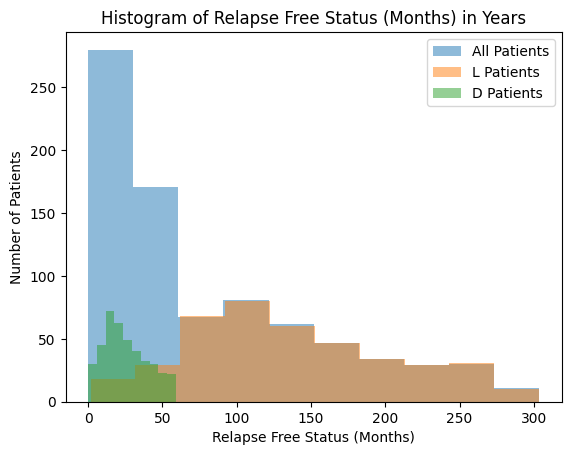

In [406]:
fig, ax = plt.subplots()
column = 'Relapse Free Status (Months)'

clinical_df[column].astype(float).plot(kind='hist', ax=ax, alpha=0.5, label='All Patients')
clinical_L_df[column].astype(float).plot(kind='hist', ax=ax, alpha=0.5, label='L Patients')
clinical_D_df[column].astype(float).plot(kind='hist', ax=ax, alpha=0.5, label='D Patients')

ax.set_title(f'Histogram of {column} in Years')
ax.set_xlabel(column)
ax.set_ylabel('Number of Patients')
ax.legend()

plt.savefig(results_dir / 'relapse_hist_combined.png', dpi=300)

plt.show()

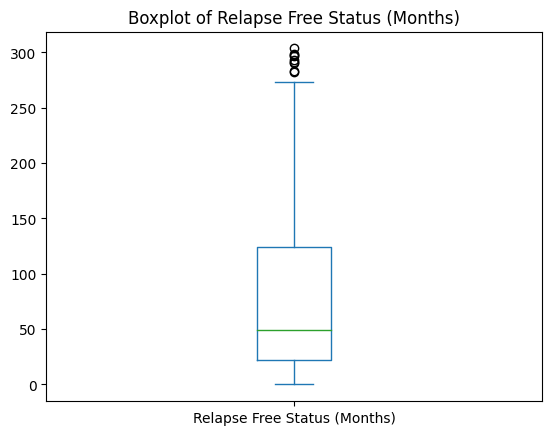

In [407]:
clinical_df['Relapse Free Status (Months)'].astype(float).plot(kind='box', 
                                                            title = 'Boxplot of Relapse Free Status (Months)')
plt.savefig(results_dir/'relapse_box.png')

### 1.6. Checking if any patients have missing "Overall Survival (Months)" information

In [322]:
subset = ~clinical_df['Overall Survival (Months)'].isna()
clinical_df = clinical_df.loc[subset]
clinical_df.shape

(812, 18)